# Duration "what-if" simulation with empirical distributions 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(42)

In [3]:
def left_trunc(data):
    zeros = np.zeros(data.shape[0])
    return np.maximum(zeros, data)

In [4]:
def dump_quantiles(data_ctrl, data_exp):
    q = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_ctrl = np.quantile(data_ctrl, q)
    q_exp = np.quantile(data_exp, q)
    print("Baseline        Experiment")
    print(f"p25={q_ctrl[0]:6.2f}      p25={q_exp[0]:6.2f}")
    print(f"p50={q_ctrl[1]:6.2f}      p50={q_exp[1]:6.2f}")
    print(f"p75={q_ctrl[2]:6.2f}      p75={q_exp[2]:6.2f}")
    print(f"p90={q_ctrl[3]:6.2f}      p90={q_exp[3]:6.2f}")
    print(f"p95={q_ctrl[4]:6.2f}      p95={q_exp[4]:6.2f}")
    print(f"p99={q_ctrl[5]:6.2f}      p99={q_exp[5]:6.2f}")

In [5]:
def plot_data(data, xlabel, plot_range):
    plt.figure(figsize=(8, 4))
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.hist(data, bins=100, range=plot_range)
    plt.show()

In [6]:
def plot_sim_vs_observed(data_obs, title_obs, data_sim, title_sim, plot_range):
    fig, ax = plt.subplots(nrows=2, ncols=1, tight_layout=True, sharex=True, sharey=False, figsize=(8, 5))

    ax[0].hist(data_obs, bins=100, range=plot_range)
    ax[0].set_title(title_obs)
    ax[0].set_ylabel("Count")

    ax[1].hist(data_sim, bins=100, range=plot_range)
    ax[1].set_title(title_sim)
    ax[1].set_xlabel("Duration (ms)")
    ax[1].set_ylabel("Count")

    plt.show()

## 1 Generate observations

Our hypothetical process is a web service endpoint that queries a database for a list of records, does some processing on each, and then returns the result of that processing to the user. Both query time and processing time are roughly linear in the size of the record list.

There are two request classes: an "small" class and a "large" class. "Small" and "large" refer to the number of records returned rather than the number of requests. Indeed we will have more small requests than large requests.

Even though we're manufacturing this data, we'll treat it as actual observations for the purposes of this notebook. That is, we will treat the manufactured data as the simulation target; it's not itself the simulation.

In [7]:
# Counts for small vs large requests
n_total = 20000
n_small = 15000
n_large = n_total - n_small

query_err_small = rng.normal(0.0, 3.0, n_small)
query_err_large = rng.normal(0.0, 3.0, n_large)
query_dur_small = left_trunc(65.3 + rng.lognormal(1.6, 1.0, n_small) + query_err_small)
query_dur_large = left_trunc(85.2 + rng.lognormal(1.6, 1.0, n_large) + query_err_large)
query_dur = np.hstack((query_dur_small, query_dur_large))

cpu_err_small = rng.normal(0.0, 3.0, n_small)
cpu_err_large = rng.normal(0.0, 3.0, n_large)
cpu_dur_small = left_trunc(10.0 + 0.3 * query_dur_small + cpu_err_small)
cpu_dur_large = left_trunc(38.0 + 0.3 * query_dur_large + cpu_err_large)
cpu_dur = np.hstack((cpu_dur_small, cpu_dur_large))

total_dur = query_dur + cpu_dur

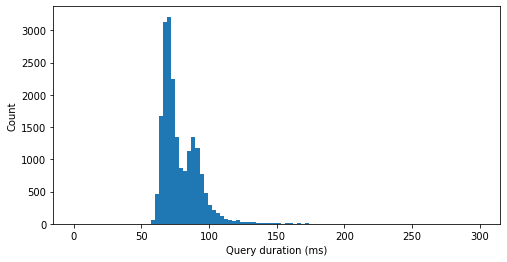

In [8]:
plot_data(query_dur, "Query duration (ms)", [0, 300])

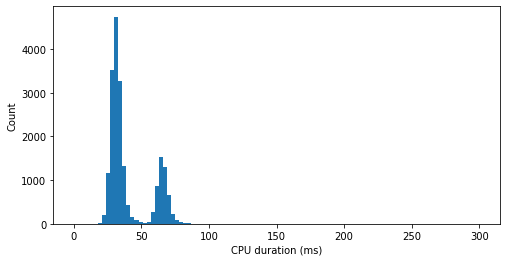

In [9]:
plot_data(cpu_dur, "CPU duration (ms)", [0, 300])

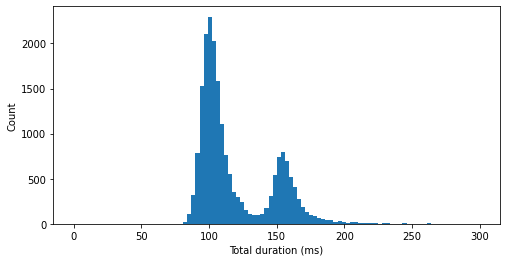

In [10]:
plot_data(total_dur, "Total duration (ms)", [0, 300])

Text(0, 0.5, 'CPU duration (ms)')

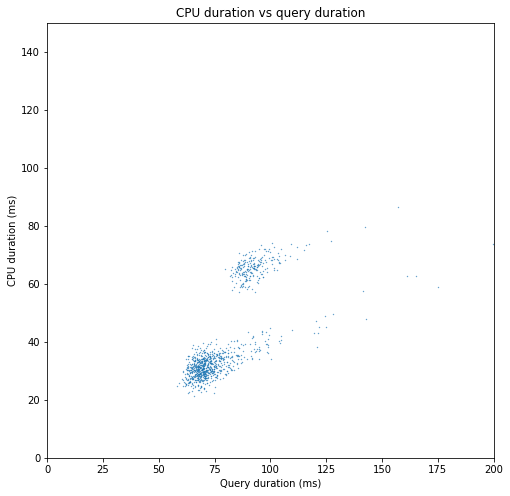

In [11]:
i = random.sample(range(0, n_total), 1000)
plt.figure(figsize=(8, 8))
plt.title("CPU duration vs query duration")
plt.scatter(x=query_dur[i], y=cpu_dur[i], s=0.1)
plt.xlim(0, 200)
plt.ylim(0, 150)
plt.xlabel("Query duration (ms)")
plt.ylabel("CPU duration (ms)")

## 2 Sampling from an empirical distribution

In [12]:
n_sample = 20000
i_sample = random.choices(range(0, n_total), k=n_sample)
query_sample = query_dur[i_sample]

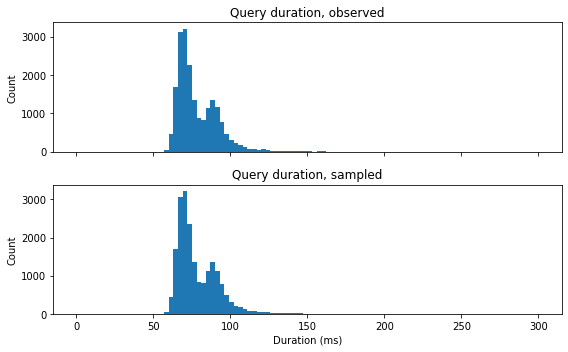

In [13]:
plot_sim_vs_observed(
    query_dur, "Query duration, observed",
    query_sample, "Query duration, sampled",
    [0, 300])

In [14]:
dump_quantiles(query_dur, query_sample)

Baseline        Experiment
p25= 68.71      p25= 68.74
p50= 73.77      p50= 73.70
p75= 87.12      p75= 87.04
p90= 94.88      p90= 94.93
p95=101.78      p95=101.72
p99=125.35      p99=123.57


## 3 What-if analysis

In [15]:
def run_sim(query_data, cpu_data, n, k_query=1.0, k_cpu=1.0):
    i_sample = random.choices(range(0, n_total), k=n)
    return k_query * query_data[i_sample] + k_cpu * cpu_data[i_sample]

In [16]:
n_sim = 20000

### Verify the simulation

In [17]:
sim_sample_baseline = run_sim(query_dur, cpu_dur, n_sim)

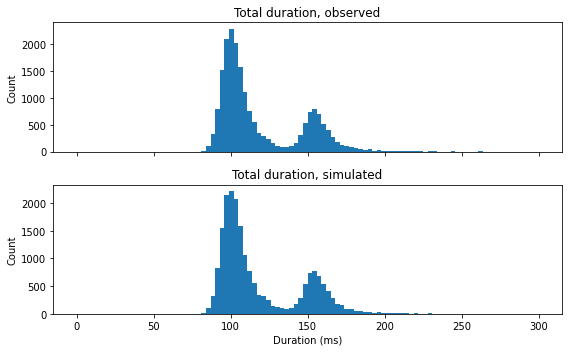

In [18]:
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_baseline, "Total duration, simulated",
    [0, 300])

In [19]:
dump_quantiles(total_dur, sim_sample_baseline)

Baseline        Experiment
p25= 99.18      p25= 99.08
p50=106.39      p50=106.31
p75=146.00      p75=145.18
p90=159.56      p90=159.55
p95=166.86      p95=166.69
p99=191.88      p99=191.24


### Experiment \#1: faster queries

In [20]:
sim_sample_whatif_query = run_sim(query_dur, cpu_dur, n_sim, k_query=0.8)

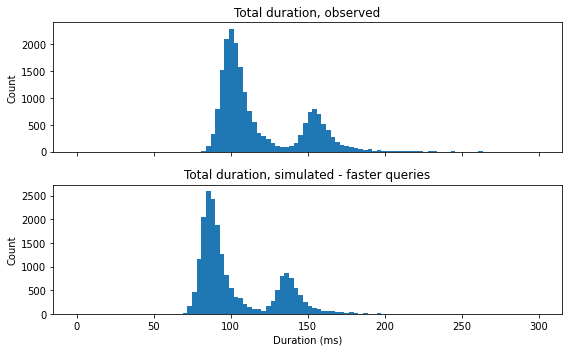

In [21]:
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_whatif_query, "Total duration, simulated - faster queries",
    [0, 300])

In [22]:
dump_quantiles(total_dur, sim_sample_whatif_query)

Baseline        Experiment
p25= 99.18      p25= 85.33
p50=106.39      p50= 91.67
p75=146.00      p75=128.08
p90=159.56      p90=140.82
p95=166.86      p95=146.98
p99=191.88      p99=167.63


### Experiment \#2: faster CPU

In [23]:
sim_sample_whatif_cpu = run_sim(query_dur, cpu_dur, n_sim, k_cpu=0.8)

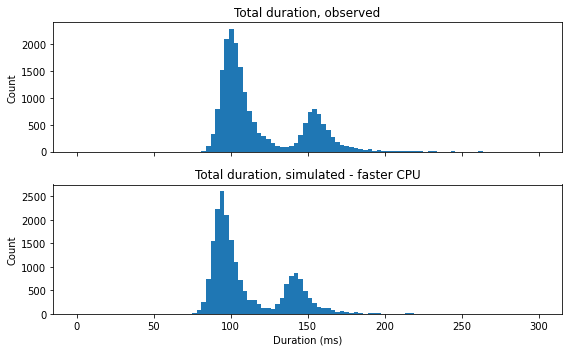

In [24]:
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_whatif_cpu, "Total duration, simulated - faster CPU",
    [0, 300])

In [25]:
dump_quantiles(total_dur, sim_sample_whatif_cpu)

Baseline        Experiment
p25= 99.18      p25= 93.17
p50=106.39      p50= 99.67
p75=146.00      p75=134.00
p90=159.56      p90=146.38
p95=166.86      p95=153.25
p99=191.88      p99=176.35


### Experiment \#3: faster queries and CPU 

In [26]:
sim_sample_whatif_both = run_sim(query_dur, cpu_dur, n_sim, k_query=0.8, k_cpu=0.8)

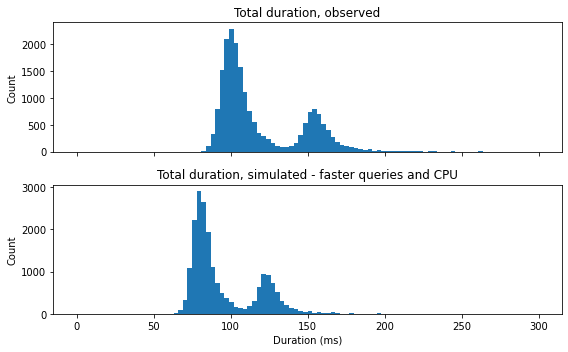

In [27]:
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_whatif_both, "Total duration, simulated - faster queries and CPU",
    [0, 300])

In [28]:
dump_quantiles(total_dur, sim_sample_whatif_both)

Baseline        Experiment
p25= 99.18      p25= 79.32
p50=106.39      p50= 84.90
p75=146.00      p75=116.15
p90=159.56      p90=127.44
p95=166.86      p95=133.47
p99=191.88      p99=154.66


### Experiment \#4: slower queries

In [29]:
sim_sample_whatif_query2 = run_sim(query_dur, cpu_dur, n_sim, k_query=1.3)

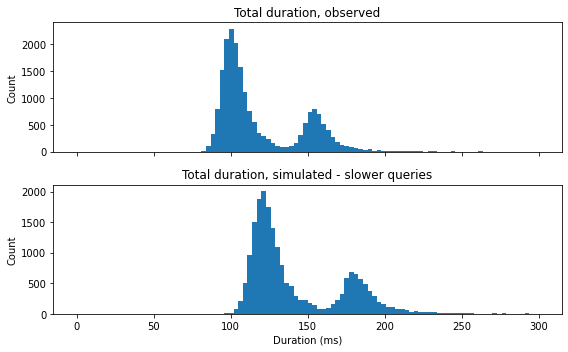

In [30]:
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_whatif_query2, "Total duration, simulated - slower queries",
    [0, 300])

In [31]:
dump_quantiles(total_dur, sim_sample_whatif_query2)

Baseline        Experiment
p25= 99.18      p25=119.76
p50=106.39      p50=128.26
p75=146.00      p75=172.20
p90=159.56      p90=187.68
p95=166.86      p95=197.48
p99=191.88      p99=230.36
